In [268]:
import gzip
import json
from collections import defaultdict
from datetime import datetime
import math
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
import string
from sklearn import linear_model
from tqdm import tqdm
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import statistics
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import scipy.sparse as sparse
from implicit import bpr
from surprise import SVD, Reader, Dataset, SVDpp
from gensim.models import Word2Vec
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.utils.data import RandomSampler, DataLoader, TensorDataset
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

def set_seed(seed):
	random.seed(seed)
	np.random.seed(seed)
	torch.manual_seed(seed)
	if torch.cuda.is_available():
		torch.cuda.manual_seed(seed)
	if torch.backends.mps.is_available():
		torch.manual_seed(seed)

set_seed(42)



In [269]:
metadata = []
f = gzip.open("meta_Amazon_Fashion.jsonl.gz")
for l in f:
    d = json.loads(l)
    metadata.append(d)
f.close()
metadata = pd.DataFrame(metadata)

In [270]:
reviews = []
f = gzip.open("Amazon_Fashion.jsonl.gz")
for l in f:
    d = json.loads(l)
    reviews.append(d)
f.close()
reviews= pd.DataFrame(reviews)

In [4]:
print("Total reviews: ",reviews.shape[0])
print("Total Users: ", reviews['user_id'].nunique())
print("Total Items: ", metadata.shape[0])


Total reviews:  2500939
Total Users:  2035490
Total Items:  826108


In [141]:
reviews['timestamp']= reviews['timestamp'].apply(lambda x:datetime.fromtimestamp(x/1000))
print("Timestamp min: ", min(reviews['timestamp']))
print("Timestamp max: ", max(reviews['timestamp']))

Timestamp min:  2002-05-06 18:51:28
Timestamp max:  2023-09-10 20:24:38.515000


In [142]:
reviews['year'] = reviews['timestamp'].dt.year
reviews['month'] = reviews['timestamp'].dt.month
reviews['day_of_week'] = reviews['timestamp'].dt.dayofweek
reviews['hour'] = reviews['timestamp'].dt.hour

([<matplotlib.axis.XTick at 0x37764e510>,
 [Text(2002, 0, '2002'),
  Text(2003, 0, '2003'),
  Text(2004, 0, '2004'),
  Text(2005, 0, '2005'),
  Text(2006, 0, '2006'),
  Text(2007, 0, '2007'),
  Text(2008, 0, '2008'),
  Text(2009, 0, '2009'),
  Text(2010, 0, '2010'),
  Text(2011, 0, '2011'),
  Text(2012, 0, '2012'),
  Text(2013, 0, '2013'),
  Text(2014, 0, '2014'),
  Text(2015, 0, '2015'),
  Text(2016, 0, '2016'),
  Text(2017, 0, '2017'),
  Text(2018, 0, '2018'),
  Text(2019, 0, '2019'),
  Text(2020, 0, '2020'),
  Text(2021, 0, '2021'),
  Text(2022, 0, '2022'),
  Text(2023, 0, '2023')])

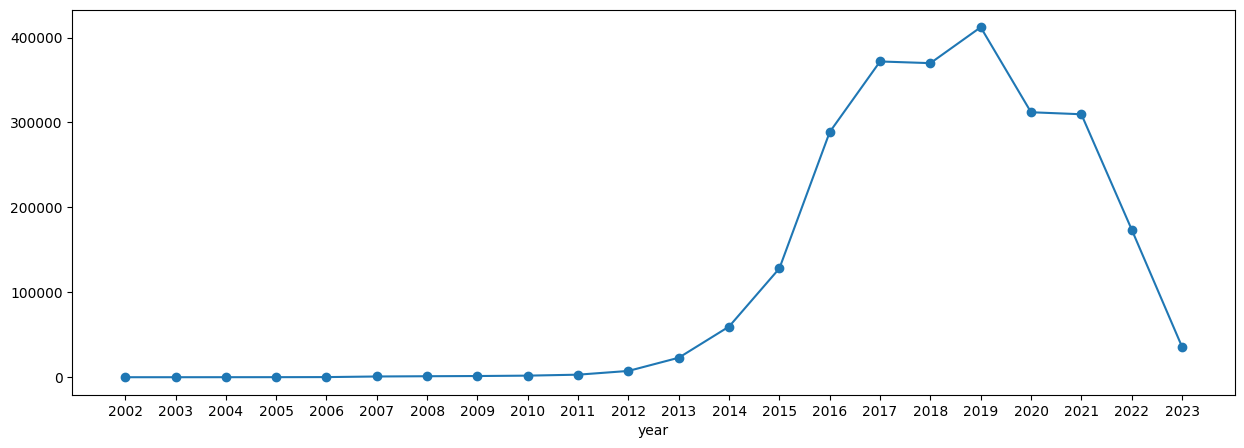

In [7]:
year_wise = reviews['year'].value_counts()
year_wise = pd.DataFrame({'year': year_wise.index, 'review_count':year_wise.values})
year_wise = year_wise.sort_values(by='year')
plt.figure(figsize=(15,5))
plt.plot(year_wise['year'], year_wise['review_count'], marker='o')
plt.xlabel("year")
plt.xticks(range(2002,2024))

In [143]:
reviews= reviews[reviews['timestamp']>=pd.to_datetime('2015-01-01')]
print("Total reviews: ",reviews.shape[0])
print("Total Users: ", reviews['user_id'].nunique())
print("Total Items: ", reviews['asin'].nunique())

Total reviews:  2402272
Total Users:  1958042
Total Items:  855286


In [144]:
duplicates = reviews[reviews.duplicated(subset=["user_id", "asin","timestamp"])]
duplicates.shape

(24199, 14)

In [145]:
reviews = reviews.drop_duplicates(subset=["user_id", "asin","timestamp"])

In [11]:
reviews.isna().sum()

rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
year                 0
month                0
day_of_week          0
hour                 0
review_age_days      0
dtype: int64

<Axes: xlabel='rating', ylabel='count'>

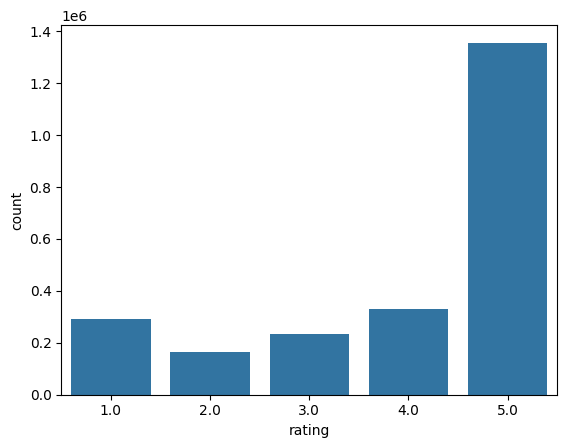

In [13]:
sns.barplot(reviews['rating'].value_counts())

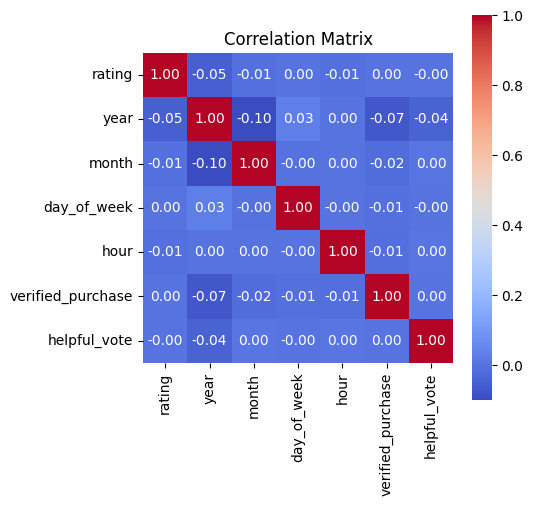

In [10]:
correlation_matrix  = reviews[['rating', 'year', 'month', 'day_of_week', 'hour','verified_purchase','helpful_vote']].corr()
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix')
plt.show()

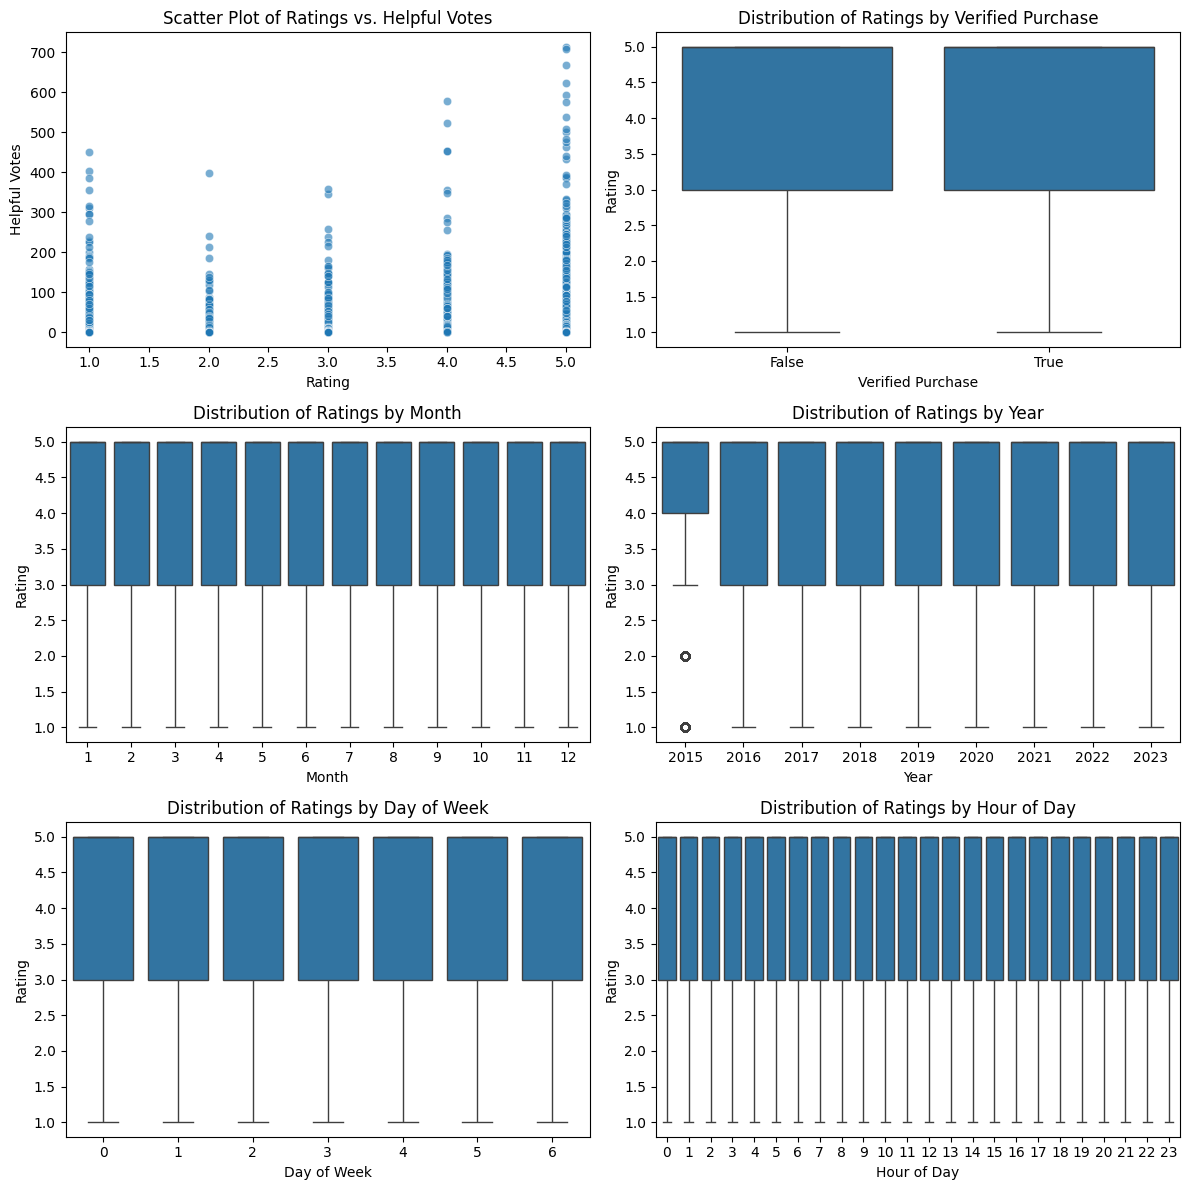

In [149]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

# Scatter plot of Ratings vs. Helpful Votes
sns.scatterplot(x='rating', y='helpful_vote', data=reviews, alpha=0.6, ax=axes[0, 0])
axes[0, 0].set_title("Scatter Plot of Ratings vs. Helpful Votes")
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Helpful Votes")

# Box plot of Ratings by Verified Purchase
sns.boxplot(x='verified_purchase', y='rating', data=reviews, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Ratings by Verified Purchase')
axes[0, 1].set_xlabel('Verified Purchase')
axes[0, 1].set_ylabel('Rating')

# Box plot of Ratings by Month
sns.boxplot(x='month', y='rating', data=reviews, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Ratings by Month')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Rating')

# Box plot of Ratings by Year
sns.boxplot(x='year', y='rating', data=reviews, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Ratings by Year')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Rating')

# Box plot of Ratings by Day of Week
sns.boxplot(x='day_of_week', y='rating', data=reviews, ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Ratings by Day of Week')
axes[2, 0].set_xlabel('Day of Week')
axes[2, 0].set_ylabel('Rating')

# Box plot of Ratings by Hour of Day
sns.boxplot(x='hour', y='rating', data=reviews, ax=axes[2, 1])
axes[2, 1].set_title('Distribution of Ratings by Hour of Day')
axes[2, 1].set_xlabel('Hour of Day')
axes[2, 1].set_ylabel('Rating')

# Adjust layout
plt.tight_layout()
plt.savefig('ratings_analysis.png')
plt.show()

## Keep only user and item that have atleast 4 entries, for modelling purpose

In [151]:
user_counts = reviews["user_id"].value_counts()
item_counts = reviews["asin"].value_counts()

valid_users = user_counts[user_counts >= 4].index
valid_items = item_counts[item_counts >= 4].index

reviews = reviews[reviews["user_id"].isin(valid_users) & reviews["asin"].isin(valid_items)]

<Axes: xlabel='rating', ylabel='count'>

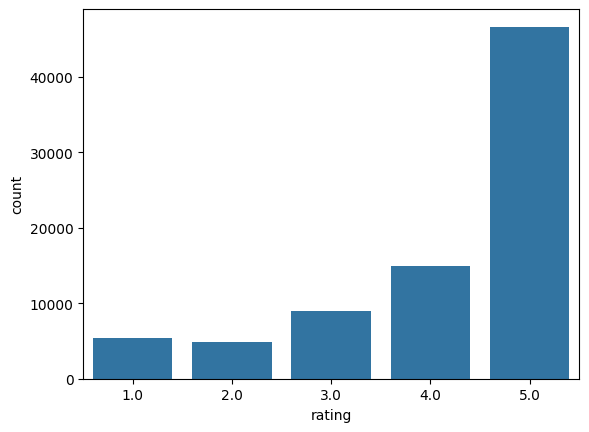

In [13]:
sns.barplot(reviews['rating'].value_counts())

In [152]:
metadata = metadata.drop_duplicates(subset=["parent_asin"])

In [153]:
metadata = metadata[metadata['parent_asin'].isin(reviews['parent_asin'].unique())]

In [154]:
metadata[['main_category', 'average_rating', 'rating_number', 'price', 'store', 'bought_together']].describe(include='all')

,main_category,average_rating,rating_number,price,store,bought_together
count,42333,42333.000000,42333.000000,3713.000000,40860,0
unique,1,NaN,NaN,NaN,12866,0
top,AMAZON FASHION,NaN,NaN,NaN,Romwe,NaN
freq,42333,NaN,NaN,NaN,379,NaN
mean,NaN,3.856245,78.444594,24.804966,NaN,NaN
std,NaN,0.531205,519.016059,53.773916,NaN,NaN
min,NaN,1.200000,1.000000,0.010000,NaN,NaN
25%,NaN,3.500000,11.000000,9.990000,NaN,NaN
50%,NaN,3.900000,21.000000,14.990000,NaN,NaN
75%,NaN,4.200000,45.000000,24.950000,NaN,NaN


In [12]:
metadata.isna().sum()

main_category          0
title                  0
average_rating         0
rating_number          0
features               0
description            0
price              38620
images                 0
videos                 0
store               1473
categories             0
details                0
parent_asin            0
bought_together    42333
dtype: int64

In [13]:
metadata['features'].apply(lambda x: len(x) == 0).sum()

15914

In [14]:
metadata['description'].apply(lambda x: len(x) == 0).sum()

39247

In [120]:
metadata['categories'].apply(lambda x: len(x) == 0).sum()

42333

In [15]:
unique_keys = set()
for d in metadata['details']:
    unique_keys.update(d.keys())
len(unique_keys)

252

In [16]:
metadata['store'] = metadata['store'].fillna('Unknown')

In [155]:
metadata = metadata.drop(['images','videos','categories', 'bought_together','main_category', 'price','description','details','features','store'],axis=1).reset_index(drop=True)

In [156]:
reviews = reviews.drop(['images','year'],axis=1).reset_index(drop=True)

In [ ]:
# metadata = pd.get_dummies(metadata, columns=['store'])

In [157]:
reviews = reviews.rename(columns={'title':'review_title'})
metadata = metadata.rename(columns={'title':'item_title'})

In [158]:
reviews = reviews.merge(metadata, on='parent_asin', how='left')

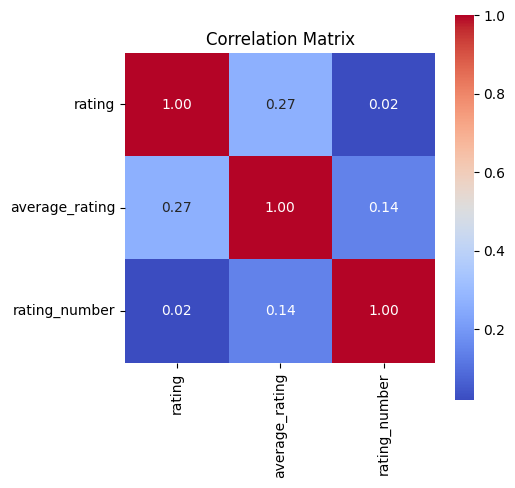

In [17]:
correlation_matrix = reviews[['rating', 'average_rating','rating_number']].corr()
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix')
plt.show()

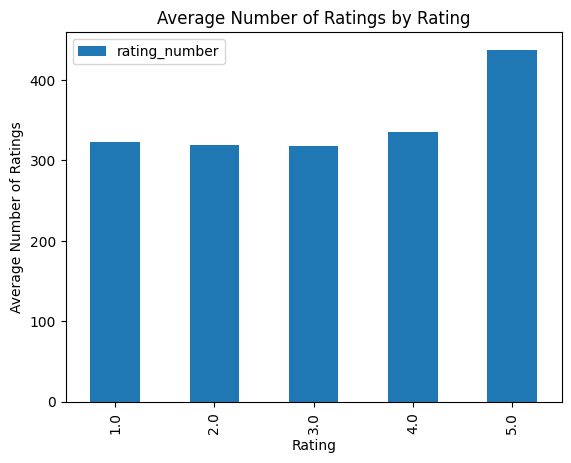

In [162]:
reviews.groupby(['rating']).agg({'rating_number':'mean'}).plot(kind='bar')
plt.title('Average Number of Ratings by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Number of Ratings')
plt.show()

In [229]:
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def preprocess_text(self, text):
        text = text.lower()
        text = ''.join(char for char in text if char.isalnum() or char.isspace())
        text = ' '.join(self.lemmatizer.lemmatize(word) for word in text.split() if word not in self.stop_words)
        return text
    

In [230]:
preprocessor = TextPreprocessor()
reviews['text'] = reviews['text'].apply(preprocessor.preprocess_text)
reviews['review_title'] = reviews['review_title'].apply(preprocessor.preprocess_text)
reviews['item_title'] = reviews['item_title'].apply(preprocessor.preprocess_text)

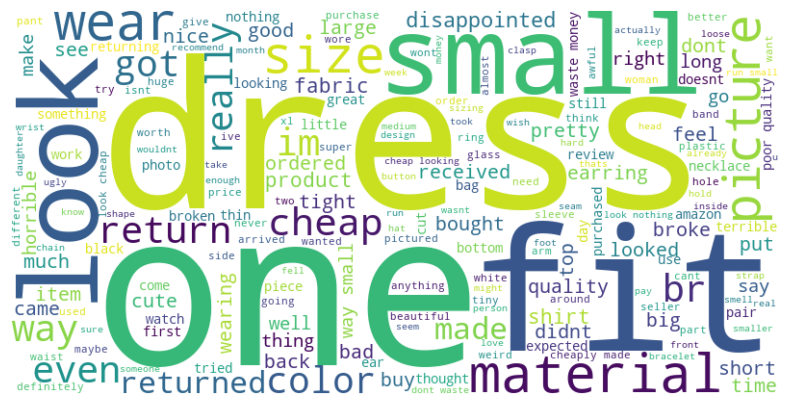

In [231]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(reviews[reviews['rating']==1]['text'].tolist()))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

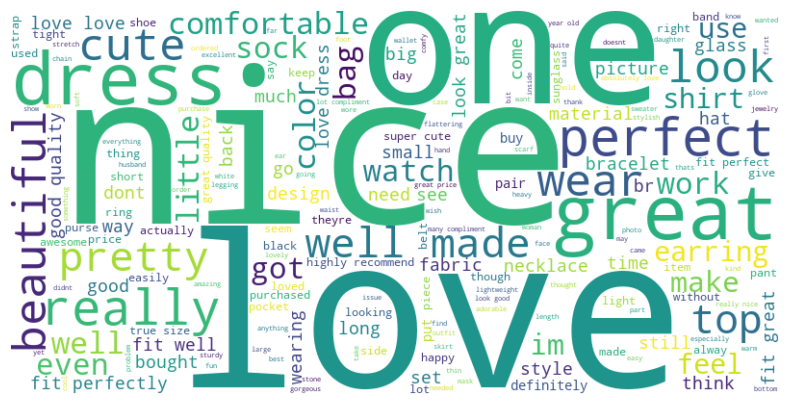

In [232]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(reviews[reviews['rating']==5]['text'].tolist()))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

In [234]:
test_perc = 0.15

def split_user_data(user_df):
    user_df = user_df.sample(frac=1, random_state=42) 
    n_test = int(round(test_perc * len(user_df)))
    return user_df.head(len(user_df) - n_test), user_df.tail(n_test)

splits = reviews.groupby('user_id').apply(split_user_data)

reviews_train = pd.concat([split[0] for split in splits])
reviews_valid = pd.concat([split[1] for split in splits])

reviews_train = reviews_train.sample(frac=1, random_state=42).reset_index(drop=True)
reviews_valid = reviews_valid.sample(frac=1, random_state=42).reset_index(drop=True)

In [20]:
print("Train reviews: ", reviews_train.shape[0])
print("Users: ", reviews_train['user_id'].nunique())
print("Items: ", reviews_train['parent_asin'].nunique())

Train reviews:  72295
Users:  26410
Items:  39965


In [21]:
print("Test reviews: ", reviews_valid.shape[0])
print("Users: ", reviews_valid['user_id'].nunique())
print("Items: ", reviews_valid['parent_asin'].nunique())
print("Common users: ", len(set(reviews_train['user_id'].unique()) & set(reviews_valid['user_id'].unique())))
print("Common items: ", len(set(reviews_train['parent_asin'].unique()) & set(reviews_valid['parent_asin'].unique())))

Test reviews:  8534
Users:  7931
Items:  6857
Common users:  7931
Common items:  4489


In [236]:
def xgb_evaluator(X_train, X_valid, y_train, y_valid, model=None):
    if model==None:
        model = XGBRegressor(
            objective='reg:squarederror',
            learning_rate=0.2,
            max_depth=5,
            colsample_bytree=0.8,
            subsample=0.8,
            alpha=0.6,
            reg_lambda=0.5,
            n_estimators=200 
        )
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_train_clipped = np.clip(y_pred_train, 0, 5)
    mse_train = mean_squared_error(y_train, y_pred_train_clipped)
    print(f'Train MSE: {mse_train}')

    y_pred_valid = model.predict(X_valid)
    y_pred_valid_clipped = np.clip(y_pred_valid, 0, 5)
    mse_valid = mean_squared_error(y_valid, y_pred_valid_clipped)
    print(f'Valid MSE: {mse_valid}')
    return model

In [237]:

X_train,X_valid, y_train,y_valid  = reviews_train['text'], reviews_valid['text'], reviews_train['rating'], reviews_valid['rating']
cv = CountVectorizer(max_features=2000)
X_train_cv = cv.fit_transform(X_train)
X_valid_cv = cv.transform(X_valid)
model = xgb_evaluator(X_train_cv, X_valid_cv, y_train, y_valid)

Train MSE: 0.7256315218769216
Valid MSE: 0.753157342312715


In [238]:
cv = CountVectorizer(max_features=4000, ngram_range=(1,2))
X_train_cv = cv.fit_transform(X_train)
X_valid_cv = cv.transform(X_valid)
model = xgb_evaluator(X_train_cv, X_valid_cv, y_train, y_valid)

Train MSE: 0.7171225909971076
Valid MSE: 0.7424122037838896


In [239]:
feature_names = cv.get_feature_names_out()

feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

top_features = feature_importance_df.sort_values('importance', ascending=False)

print(top_features.head(20))


           feature  importance
2902      returned    0.021215
3746         waste    0.019844
2405  nothing like    0.019571
587   cheaply made    0.015941
2903     returning    0.014962
2653          poor    0.014251
485          broke    0.012761
3466      terrible    0.012024
580          cheap    0.011071
3721   wanted love    0.010893
1680      horrible    0.010401
3763     way small    0.010241
2901        return    0.010063
946   disappointed    0.009904
586        cheaply    0.009581
2655        poorly    0.008308
3816         weird    0.008084
723     compliment    0.007893
1645        highly    0.006205
487         broken    0.006201


In [240]:
tfidf = TfidfVectorizer(max_features=2000)
X_train_tf = tfidf.fit_transform(X_train)
X_valid_tf = tfidf.transform(X_valid)
model = xgb_evaluator(X_train_tf, X_valid_tf, y_train, y_valid)

Train MSE: 0.6477044932852899
Valid MSE: 0.7089694203840367


In [241]:
tfidf = TfidfVectorizer(max_features=4000, ngram_range=(1,2))
X_train_tf = tfidf.fit_transform(X_train)
X_valid_tf = tfidf.transform(X_valid)
model = xgb_evaluator(X_train_tf, X_valid_tf, y_train, y_valid)

Train MSE: 0.6412336637573421
Valid MSE: 0.7046513275207347


In [243]:
feature_names = tfidf.get_feature_names_out()

feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

top_features = feature_importance_df.sort_values('importance', ascending=False)

print(top_features.head(20))

           feature  importance
2405  nothing like    0.018527
3746         waste    0.015516
3466      terrible    0.011503
3721   wanted love    0.010481
2902      returned    0.010433
946   disappointed    0.010327
2901        return    0.009515
1680      horrible    0.008755
2653          poor    0.008251
485          broke    0.008167
580          cheap    0.007920
2903     returning    0.007516
1645        highly    0.007152
2568       perfect    0.006847
3191         small    0.006584
2655        poorly    0.006538
3763     way small    0.006212
2073          love    0.006013
1533         great    0.005752
587   cheaply made    0.005483


In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

def extract_bert_features_batch(texts, batch_size=32, max_length=128):
    features = []
    
    for i in tqdm(range(0, len(texts), batch_size)):
        texts = list(texts)
        batch = texts[i:i+batch_size]
        
        inputs = tokenizer(
            batch, 
            return_tensors='pt', 
            max_length=max_length, 
            padding='max_length', 
            truncation=True
        ).to(device)
        
        with torch.no_grad():
            outputs = bert_model(**inputs)
            # batch_features =  outputs.last_hidden_state[:, 0, :].cpu().numpy() #[CLS] token output
            batch_features = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        
        features.append(batch_features)
    
    return np.vstack(features)

X_bert = extract_bert_features_batch(X_train, batch_size=256)
X_valid_bert = extract_bert_features_batch(X_valid, batch_size=256)


Using device: mps


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model = xgb_evaluator(X_bert, X_valid_bert, y_train, y_valid)

Bert
Train MSE: 0.6852563240045191
Test MSE: 0.8147957867679335


In [244]:

X_train_tokenized = [text.split() for text in X_train]
X_valid_tokenized = [text.split() for text in X_valid]
word2vec_model = Word2Vec(sentences=X_train_tokenized, vector_size=100, window=5, min_count=1, workers=4)

def vectorize_texts(texts, word2vec_model):
    vectors = []
    for text in texts:
        words = text.split()
        word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
        if word_vectors:
            vectors.append(np.mean(word_vectors, axis=0))
        else:
            vectors.append(np.zeros(word2vec_model.vector_size))
    return np.array(vectors)

X_train_w2v = vectorize_texts(X_train, word2vec_model)
X_valid_w2v = vectorize_texts(X_valid, word2vec_model)
model = xgb_evaluator(X_train_w2v,X_valid_w2v, y_train, y_valid )

Train MSE: 0.543986978411133
Valid MSE: 0.6972686911961015


In [245]:
X_train,X_valid, y_train,y_valid  = reviews_train['review_title']+' '+ reviews_train['text'], reviews_valid['review_title']+' '+reviews_valid['text'], reviews_train['rating'], reviews_valid['rating']
cv = CountVectorizer(max_features=2000)
X_train_cv = cv.fit_transform(X_train)
X_valid_cv = cv.transform(X_valid)
model = xgb_evaluator(X_train_cv, X_valid_cv, y_train, y_valid)

Train MSE: 0.5312709589871419
Valid MSE: 0.5366286677829444


In [246]:
cv = CountVectorizer(max_features=4000, ngram_range=(1,2))
X_train_cv = cv.fit_transform(X_train)
X_valid_cv = cv.transform(X_valid)
model = xgb_evaluator(X_train_cv, X_valid_cv, y_train, y_valid)

Train MSE: 0.512624746173742
Valid MSE: 0.5059409110856423


In [247]:
tfidf = TfidfVectorizer(max_features=2000)
X_train_tf = tfidf.fit_transform(X_train)
X_valid_tf = tfidf.transform(X_valid)
model = xgb_evaluator(X_train_tf, X_valid_tf, y_train, y_valid)

Train MSE: 0.47872210862255404
Valid MSE: 0.5160145670259488


In [248]:
tfidf = TfidfVectorizer(max_features=4000, ngram_range=(1,2))
X_train_tf = tfidf.fit_transform(X_train)
X_valid_tf = tfidf.transform(X_valid)
model = xgb_evaluator(X_train_tf, X_valid_tf, y_train, y_valid)

Train MSE: 0.4665765449861767
Valid MSE: 0.48931128811832175


In [249]:
from gensim.models import Word2Vec
X_train_tokenized = [text.split() for text in X_train]
X_valid_tokenized = [text.split() for text in X_valid]
word2vec_model = Word2Vec(sentences=X_train_tokenized, vector_size=100, window=5, min_count=1, workers=4)

X_train_w2v = vectorize_texts(X_train, word2vec_model)
X_valid_w2v = vectorize_texts(X_valid, word2vec_model)
model = xgb_evaluator(X_train_w2v,X_valid_w2v, y_train, y_valid)

Train MSE: 0.4042329000270417
Valid MSE: 0.5295938263917613


In [53]:
X_bert = extract_bert_features_batch(X_train, batch_size=256)
X_valid_bert = extract_bert_features_batch(X_valid, batch_size=256)
model = xgb_evaluator(X_bert, X_valid_bert, y_train, y_valid)

100%|██████████| 34/34 [01:04<00:00,  1.89s/it]


Train MSE: 0.4189149810655483
Valid MSE: 0.6698021614423918


In [251]:
reviews_train['combined_text'] = reviews_train['review_title'] + ' ' + reviews_train['text']
reviews_valid['combined_text'] = reviews_valid['review_title'] + ' ' + reviews_valid['text']

text_vectorizer = CountVectorizer(max_features=2000)

numerical_features = ['rating_number', 'average_rating']

preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_vectorizer, 'combined_text'), 
        ('num', StandardScaler(), numerical_features) 
    ]
)

X_train = preprocessor.fit_transform(reviews_train)
X_valid = preprocessor.transform(reviews_valid)

y_train = reviews_train['rating']
y_valid = reviews_valid['rating']
model= xgb_evaluator(X_train, X_valid, y_train, y_valid)

Train MSE: 0.5089517197535015
Valid MSE: 0.5268860251713238


In [252]:
text_vectorizer = CountVectorizer(max_features=4000, ngram_range=(1,2))

numerical_features = ['rating_number', 'average_rating']

preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_vectorizer, 'combined_text'), 
        ('num', StandardScaler(), numerical_features) 
    ]
)

X_train = preprocessor.fit_transform(reviews_train)
X_valid = preprocessor.transform(reviews_valid)

y_train = reviews_train['rating']
y_valid = reviews_valid['rating']
model= xgb_evaluator(X_train, X_valid, y_train, y_valid)

Train MSE: 0.4941905816860016
Valid MSE: 0.5012123573373856


In [253]:

text_vectorizer = TfidfVectorizer(max_features=2000)

numerical_features = ['rating_number']

preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_vectorizer, 'combined_text'),  
        ('num', StandardScaler(), numerical_features) 
    ]
)

X_train = preprocessor.fit_transform(reviews_train)
X_valid = preprocessor.transform(reviews_valid)

y_train = reviews_train['rating']
y_valid = reviews_valid['rating']
model= xgb_evaluator(X_train, X_valid, y_train, y_valid)

Train MSE: 0.47796604092138373
Valid MSE: 0.513633939078113


In [254]:
text_vectorizer = TfidfVectorizer(max_features=4000, ngram_range=(1,2))


preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_vectorizer, 'combined_text'),  
        ('num', StandardScaler(), numerical_features) 
    ]
)

X_train = preprocessor.fit_transform(reviews_train)
X_valid = preprocessor.transform(reviews_valid)

y_train = reviews_train['rating']
y_valid = reviews_valid['rating']
model= xgb_evaluator(X_train, X_valid, y_train, y_valid)

Train MSE: 0.46456243228356703
Valid MSE: 0.4923843176297065


In [255]:
X_train_tokenized = [text.split() for text in reviews_train['combined_text']]
X_valid_tokenized = [text.split() for text in reviews_valid['combined_text']]

word2vec_model = Word2Vec(sentences=X_train_tokenized, vector_size=100, window=5, min_count=1, workers=4)
def vectorize_texts(texts, word2vec_model):
    vectors = []
    for text in texts:
        words = text.split()
        word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
        if word_vectors:
            vectors.append(np.mean(word_vectors, axis=0))
        else:
            vectors.append(np.zeros(word2vec_model.vector_size))
    return np.array(vectors)
X_train_text_embeddings = vectorize_texts(reviews_train['combined_text'], word2vec_model)

X_valid_text_embeddings = vectorize_texts(reviews_valid['combined_text'] , word2vec_model)

numerical_features = ['rating_number', 'average_rating']
scaler = StandardScaler()

X_train_numerical = scaler.fit_transform(reviews_train[numerical_features])
X_valid_numerical = scaler.transform(reviews_valid[numerical_features])

X_train = np.hstack((X_train_text_embeddings, X_train_numerical))
X_valid = np.hstack((X_valid_text_embeddings, X_valid_numerical))

y_train = reviews_train['rating']
y_valid = reviews_valid['rating']
model= xgb_evaluator(X_train, X_valid, y_train, y_valid)



Train MSE: 0.39174400963318323
Valid MSE: 0.5197932565309182


In [65]:
X_train = np.hstack((X_bert, X_train_numerical))
X_valid = np.hstack((X_valid_bert, X_valid_numerical))

model= xgb_evaluator(X_train, X_valid, y_train, y_valid)

Train MSE: 0.41032312045190517
Valid MSE: 0.6491837651214558


In [256]:
from collections import defaultdict

usersPerItem = defaultdict(set) 
itemsPerUser = defaultdict(set)
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)

for idx, row in reviews_train.iterrows():
    user,item, rating = row['user_id'], row['asin'], row['rating']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    ratingsPerUser[user].append((item,rating))
    ratingsPerItem[item].append((user,rating))

In [257]:
user_wise_df = reviews_train.pivot(index='user_id', columns='asin', values='rating').fillna(0)

In [258]:
user_id_to_index = {user_id: idx for idx, user_id in enumerate(user_wise_df.index)}
index_to_user_id = {idx: user_id for user_id, idx in user_id_to_index.items()}
item_id_to_index = {item_id: idx for idx, item_id in enumerate(user_wise_df.columns)}
index_to_item_id = {idx: item_id for item_id, idx in item_id_to_index.items()}

In [68]:
sparse_user_wise_df = sparse.csr_matrix(user_wise_df )
similarities = cosine_similarity(sparse_user_wise_df,dense_output=False)

In [74]:
ratingMean =np.mean(reviews_train['rating'])
def user_collaborative(df):
    for index, row in df.iterrows():
        u,i= row['user_id'], row['asin']
        if u in user_id_to_index and i in item_id_to_index:
            ratings = []
            specific_user_index = user_id_to_index[u]
            user_similarities = similarities[specific_user_index].toarray().flatten()
            valid_similarities = []
            
            for u_,r_ in ratingsPerItem[i]:
                if u==u_: continue
                ratings.append(r_)
                valid_similarities.append(user_similarities[user_id_to_index[u_]])
            if (sum(valid_similarities) > 0):
                ratingmean_i = sum(d[-1] for d in ratingsPerUser[u])/ len(ratingsPerUser[u])
                ratingmean_j = sum(d[-1] for d in ratingsPerUser[u_])/ len(ratingsPerUser[u_])
                weightedRatings = [((x-ratingmean_j)*y) for x,y in zip(ratings,valid_similarities)]
                r_pred = ratingmean_i+ (sum(weightedRatings) / sum(valid_similarities))
            else:
                r_pred = ratingMean
        elif u in user_id_to_index:
            r_pred = sum(user_wise_df.loc[u])/sum(user_wise_df.loc[u]>0)
        elif i in item_id_to_index:
            r_pred = sum(user_wise_df[i])/sum(user_wise_df[i]>0)
        else:
            r_pred = ratingMean

        r_pred = min(r_pred,5)
        df.at[index, 'predicted'] = r_pred

user_collaborative(reviews_valid)

In [75]:
np.mean((reviews_valid['rating']-reviews_valid['predicted'])**2)

1.435551643504908

In [76]:
sparse_item_wise_df = sparse.csr_matrix(user_wise_df.T)
similarities = cosine_similarity(sparse_item_wise_df,dense_output=False)

In [77]:
def item_collaborative(df):
    for index, row in df.iterrows():
        u,i= row['user_id'], row['asin']
        if u in user_id_to_index and i in item_id_to_index:
            ratings = []
            specific_item_index = item_id_to_index[i]
            item_similarities = similarities[specific_item_index].toarray().flatten()
            valid_similarities = []
            
            for i_,r_ in ratingsPerUser[u]:
                if i==i_: continue
                ratings.append(r_)
                valid_similarities.append(item_similarities[item_id_to_index[i_]])
            if (sum(valid_similarities) > 0):
                ratingmean_i = sum(d[-1] for d in ratingsPerItem[i])/ len(ratingsPerItem[i])
                ratingmean_j = sum(d[-1] for d in ratingsPerItem[i_])/ len(ratingsPerItem[i_])
                weightedRatings = [((x-ratingmean_j)*y) for x,y in zip(ratings,valid_similarities)]
                r_pred = ratingmean_i+ (sum(weightedRatings) / sum(valid_similarities))
            else:
                r_pred = ratingMean
        elif u in user_id_to_index:
            r_pred = sum(user_wise_df.loc[u])/sum(user_wise_df.loc[u]>0)
        elif i in item_id_to_index:
            r_pred = sum(user_wise_df[i])/sum(user_wise_df[i]>0)
        else:
            r_pred = ratingMean

        r_pred = min(r_pred,5)
        df.at[index, 'predicted'] = r_pred

item_collaborative(reviews_valid)

In [78]:
np.mean((reviews_valid['rating']-reviews_valid['predicted'])**2)

1.459796942600021

In [79]:
from surprise import SVD, Reader, Dataset
reader = Reader(rating_scale=(1, 5))

train_data = Dataset.load_from_df(reviews_train[['user_id', 'asin', 'rating']], reader)
trainset = train_data.build_full_trainset()

modelSVDpp = SVDpp(n_epochs=30, n_factors=5, reg_all=0.3, lr_all=0.005)
modelSVDpp.fit(trainset)

predictions = [modelSVDpp.predict(row['user_id'], row['asin'], row['rating']).est for _, row in reviews_train.iterrows()]
mse = np.mean((reviews_train['rating']-predictions)**2)

print("train mse: ", mse)

predictions = [modelSVDpp.predict(row['user_id'], row['asin'], row['rating']).est for _, row in reviews_valid.iterrows()]
mse = np.mean((reviews_valid['rating']-predictions)**2)
print("valid mse: ", mse)

train mse:  0.8297967496817571
valid mse:  1.2581968496062452


In [259]:
reviews_train['combined_text'] = reviews_train['review_title'] + ' ' + reviews_train['text']
reviews_valid['combined_text'] = reviews_valid['review_title'] + ' ' + reviews_valid['text']

text_vectorizer = TfidfVectorizer(max_features=4000, ngram_range=(1,2))

review_features_train = text_vectorizer.fit_transform(reviews_train['combined_text']).toarray()
review_features_test = text_vectorizer.transform(reviews_valid['combined_text']).toarray()
review_features_train = torch.tensor(review_features_train, dtype=torch.float32)
review_features_test = torch.tensor(review_features_test, dtype=torch.float32)

numerical_features = ['rating_number', 'average_rating']
scaler = StandardScaler()

X_train_numerical = scaler.fit_transform(reviews_train[numerical_features])
X_valid_numerical = scaler.transform(reviews_valid[numerical_features])

item_features_train = torch.tensor(X_train_numerical, dtype=torch.float32)
item_features_test = torch.tensor(X_valid_numerical , dtype=torch.float32)

user_indices_train = [user_id_to_index[user_id] for user_id in reviews_train['user_id']]
user_indices_test = [user_id_to_index.get(user_id, len(user_id_to_index)) for user_id in reviews_valid['user_id']]

item_indices_train = [item_id_to_index[item_id] for item_id in reviews_train['asin']]
item_indices_test = [item_id_to_index.get(item_id, len(item_id_to_index)) for item_id in reviews_valid['asin']]


user_indices_train = torch.tensor(user_indices_train, dtype=torch.long)
user_indices_test = torch.tensor(user_indices_test, dtype=torch.long)
item_indices_train = torch.tensor(item_indices_train, dtype=torch.long)
item_indices_test = torch.tensor(item_indices_test, dtype=torch.long)

ratings_train = torch.tensor(reviews_train['rating'].values, dtype=torch.float32)
ratings_test = torch.tensor(reviews_valid['rating'].values, dtype=torch.float32)


train_data = TensorDataset(user_indices_train, item_indices_train, ratings_train, item_features_train, review_features_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=64)


In [ ]:
class NMF(torch.nn.Module):
    def __init__(self, num_users, num_items, num_item_features, review_features_dim, latent_dim=64):
        super(NMF, self).__init__()

        self.num_users = num_users
        self.num_items = num_items
        self.num_item_features = num_item_features
        self.review_features_dim = review_features_dim
        self.latent_dim = latent_dim

        # MLP embeddings
        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item_mlp = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        # MF embeddings
        self.embedding_user_mf = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item_mf = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        # Review features embedding
        self.embedding_review = torch.nn.Linear(review_features_dim, self.latent_dim)

        # Item feature projection
        self.item_feature_projection = torch.nn.Linear(self.latent_dim + num_item_features, self.latent_dim)

        self.fc_layers = nn.Sequential(
            nn.Linear(self.latent_dim * 3, 256), 
            nn.ReLU(),
            nn.Dropout(0),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.final_layer = nn.Linear(self.latent_dim + 64, 1)

    def forward(self, user_indices, item_indices, item_features, review_features):

        # MLP embeddings
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)

        # MF embeddings
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        # Review features embedding
        review_embedding = self.embedding_review(review_features)

        item_combined = torch.cat([item_embedding_mlp, item_features], dim=-1)
        item_combined = self.item_feature_projection(item_combined)

        mf_interaction = torch.mul(user_embedding_mf, item_embedding_mf)
        x = torch.cat([user_embedding_mlp, item_combined, review_embedding], dim=-1)
        x = self.fc_layers(x)

        x = torch.cat([x, mf_interaction], dim=-1)
        x = self.final_layer(x)
        # x = torch.clamp(x, 0, 5)
        return x.squeeze()

def NMF_train(data_loader, NMF_model, test_users, test_items, test_ratings, test_item_features, test_review_features, epochs=15):

    test_users, test_items, test_ratings = test_users.to(device), test_items.to(device), test_ratings.to(device)
    test_item_features = test_item_features.to(device)
    test_review_features = test_review_features.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(NMF_model.parameters(), lr=0.00001, weight_decay=0.0005)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    best_valid_mse = float('inf') 
    best_model_path = "best_model_nmf.pth" 

    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        running_loss = 0

        for batch_id, batch in enumerate(data_loader):
            user, item, rating, item_features, review_features = [b.to(device) for b in batch]
            prediction = NMF_model(user, item, item_features, review_features)
            
            loss = criterion(prediction, rating.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            del prediction, loss

        scheduler.step()

        train_mse = running_loss / len(data_loader)
        
        test_preds = NMF_model(test_users, test_items, test_item_features, test_review_features)
        test_preds = torch.clamp(test_preds, 0, 5)
        diff = (test_preds - test_ratings).detach().cpu().numpy()
        valid_mse = np.mean(diff ** 2)

        if valid_mse < best_valid_mse:
            best_valid_mse = valid_mse
            torch.save(NMF_model.state_dict(), best_model_path)

        print(f"Epoch: {epoch+1}, Training MSE: {train_mse}, Validation MSE: {valid_mse}")

    return NMF_model
NMF_model = NMF(num_users=len(user_id_to_index)+1, num_items=len(item_id_to_index)+1, num_item_features=2, review_features_dim=review_features_train.shape[1])
NMF_model.to(device)

trained_NMF_model = NMF_train(train_dataloader, NMF_model, user_indices_test, item_indices_test, ratings_test, item_features_test, review_features_test, epochs=30)

  3%|▎         | 1/30 [00:17<08:36, 17.82s/it]

Epoch: 1, Training MSE: 8.801083222532695, Validation MSE: 3.291825532913208


  7%|▋         | 2/30 [00:34<08:00, 17.14s/it]

Epoch: 2, Training MSE: 2.67287726333711, Validation MSE: 3.197694778442383


 10%|█         | 3/30 [00:51<07:37, 16.95s/it]

Epoch: 3, Training MSE: 2.383537435373374, Validation MSE: 1.370776891708374


 13%|█▎        | 4/30 [01:07<07:15, 16.77s/it]

Epoch: 4, Training MSE: 1.018920411762938, Validation MSE: 0.7380744218826294


 17%|█▋        | 5/30 [01:24<07:01, 16.86s/it]

Epoch: 5, Training MSE: 0.7917424662978249, Validation MSE: 0.6129806041717529


 20%|██        | 6/30 [01:41<06:44, 16.85s/it]

Epoch: 6, Training MSE: 0.7760218894323416, Validation MSE: 0.9696316123008728


 23%|██▎       | 7/30 [01:58<06:31, 17.03s/it]

Epoch: 7, Training MSE: 0.9382202173756287, Validation MSE: 0.9163212180137634


 27%|██▋       | 8/30 [02:16<06:15, 17.06s/it]

Epoch: 8, Training MSE: 0.995828713371163, Validation MSE: 0.6457449197769165


 30%|███       | 9/30 [02:32<05:57, 17.01s/it]

Epoch: 9, Training MSE: 1.1385699912510088, Validation MSE: 0.8578137159347534


 33%|███▎      | 10/30 [02:49<05:39, 16.99s/it]

Epoch: 10, Training MSE: 1.582737256059077, Validation MSE: 2.284304618835449


 37%|███▋      | 11/30 [03:06<05:20, 16.88s/it]

Epoch: 11, Training MSE: 1.304739266779043, Validation MSE: 0.7754490375518799


 40%|████      | 12/30 [03:23<05:02, 16.80s/it]

Epoch: 12, Training MSE: 1.2579902926904964, Validation MSE: 1.1792190074920654


 43%|████▎     | 13/30 [03:40<04:45, 16.82s/it]

Epoch: 13, Training MSE: 0.8245307078931184, Validation MSE: 0.5431071519851685


 47%|████▋     | 14/30 [03:56<04:29, 16.83s/it]

Epoch: 14, Training MSE: 0.49731645580150385, Validation MSE: 0.8070938587188721


 50%|█████     | 15/30 [04:13<04:12, 16.85s/it]

Epoch: 15, Training MSE: 0.46501373399411683, Validation MSE: 1.0764719247817993


 53%|█████▎    | 16/30 [04:30<03:55, 16.83s/it]

Epoch: 16, Training MSE: 0.45707115908112145, Validation MSE: 0.5239423513412476


 57%|█████▋    | 17/30 [04:47<03:39, 16.86s/it]

Epoch: 17, Training MSE: 0.3766215088225044, Validation MSE: 0.7229933738708496


 60%|██████    | 18/30 [05:04<03:22, 16.91s/it]

Epoch: 18, Training MSE: 0.34883147558543537, Validation MSE: 0.4935283660888672


 63%|██████▎   | 19/30 [05:21<03:05, 16.88s/it]

Epoch: 19, Training MSE: 0.3271235951148303, Validation MSE: 0.6570888757705688


 67%|██████▋   | 20/30 [05:38<02:48, 16.89s/it]

Epoch: 20, Training MSE: 0.31889739520518123, Validation MSE: 0.4863228499889374


 70%|███████   | 21/30 [05:54<02:31, 16.78s/it]

Epoch: 21, Training MSE: 0.31794733595004127, Validation MSE: 0.6561222672462463


 73%|███████▎  | 22/30 [06:11<02:14, 16.80s/it]

Epoch: 22, Training MSE: 0.31758766288382817, Validation MSE: 0.4858003556728363


 77%|███████▋  | 23/30 [06:28<01:57, 16.83s/it]

Epoch: 23, Training MSE: 0.31574802883958397, Validation MSE: 0.64958655834198


 80%|████████  | 24/30 [06:45<01:40, 16.80s/it]

Epoch: 24, Training MSE: 0.3105711757411472, Validation MSE: 0.4822196662425995


 83%|████████▎ | 25/30 [07:02<01:24, 16.81s/it]

Epoch: 25, Training MSE: 0.30099347186958897, Validation MSE: 0.6061285138130188


 87%|████████▋ | 26/30 [07:19<01:07, 16.84s/it]

Epoch: 26, Training MSE: 0.29030668022094575, Validation MSE: 0.48093047738075256


 90%|█████████ | 27/30 [07:35<00:50, 16.86s/it]

Epoch: 27, Training MSE: 0.2664816843197409, Validation MSE: 0.5154908299446106


 93%|█████████▎| 28/30 [07:59<00:37, 18.76s/it]

Epoch: 28, Training MSE: 0.25151784025726065, Validation MSE: 0.5126516222953796


 97%|█████████▋| 29/30 [08:16<00:18, 18.41s/it]

Epoch: 29, Training MSE: 0.24844685879956305, Validation MSE: 0.5179598331451416


100%|██████████| 30/30 [08:33<00:00, 17.12s/it]

Epoch: 30, Training MSE: 0.24599079328828152, Validation MSE: 0.48658376932144165


In [262]:
NMF_model = NMF(num_users=len(user_id_to_index)+1, num_items=len(item_id_to_index)+1, num_item_features=2, review_features_dim=review_features_train.shape[1])
NMF_model.to(device)
NMF_model.load_state_dict(torch.load("best_model_nmf.pth"))

<All keys matched successfully>

In [263]:
user_indices_test = user_indices_test.to(device)
item_indices_test = item_indices_test.to(device)
item_features_test = item_features_test.to(device)
review_features_test = review_features_test.to(device)
test_preds = NMF_model(user_indices_test, item_indices_test, item_features_test, review_features_test)
test_preds  = np.clip(test_preds.detach().cpu().numpy(), 0, 5)

In [264]:
reviews_valid['nmf_pred'] = test_preds

In [ ]:
print("Test MSE: ", np.mean((reviews_valid['rating']-reviews_valid['nmf_pred'])**2))

Test MSE:  0.48093047738075256


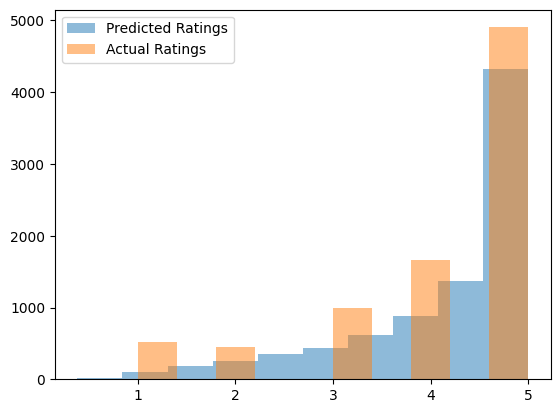

In [226]:
plt.hist(reviews_valid['nmf_pred'], alpha=0.5, label='Predicted Ratings')
plt.hist(reviews_valid['rating'], alpha=0.5, label='Actual Ratings')
plt.legend()